In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


## Load Data

In [5]:
drug_df = pd.read_excel('Healthcare_dataset.xlsx')
drug_df.drop('Ptid', axis=1, inplace=True)
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Persistency_Flag                                                    3424 non-null   object
 1   Gender                                                              3424 non-null   object
 2   Race                                                                3424 non-null   object
 3   Ethnicity                                                           3424 non-null   object
 4   Region                                                              3424 non-null   object
 5   Age_Bucket                                                          3424 non-null   object
 6   Ntm_Speciality                                                      3424 non-null   object
 7   Ntm_Specialist_Flag     

## Data Preprocessing

#### Handling Imbalanced Classes

In [6]:
# Separate majority and minority classes
majority_class = drug_df[drug_df['Persistency_Flag'] == 'Non-Persistent']
minority_class = drug_df[drug_df['Persistency_Flag'] == 'Persistent']

# Upsample minority class
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine majority class with upsampled minority class
upsampled_df = pd.concat([majority_class, minority_upsampled])
upsampled_df.head()

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Risks_Updated
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,N,0,0
2,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,Y,N,N,N,N,N,N,N,2,2
3,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,N,1,1
4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,...,N,N,N,N,N,N,N,N,1,1
5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,...,N,N,N,N,N,N,N,N,2,2


#### Encoding Categorical Features Using:
1.  SkLearn LabelEncoding for Gender
2.  Frequency encoding for other categorical columns

In [7]:
# Creating LabelEncoder instance
lb = LabelEncoder()


# Label encode the 'Gender' column
upsampled_df['Gender'] = lb.fit_transform(upsampled_df['Gender'])

# Label Encode Persistency Flag column
upsampled_df['Persistency_Flag'] = lb.fit_transform(upsampled_df['Persistency_Flag'])

# Create a new DataFrame for frequency encoding
encoded_df = pd.DataFrame()

# Loop through all columns
for column in upsampled_df.columns:
    if column in ['Gender', 'Persistency_Flag', 'Count_Of_Risks', 'Dexa_Freq_During_Rx']:
        encoded_df[column] = upsampled_df[column]
    else:
        encoding_map = upsampled_df[column].value_counts().to_dict()
        encoded_df[column] = upsampled_df[column].map(encoding_map)

# Display the result
encoded_df


,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Risks_Updated
1,0,1,109,4044,662,910,1828,2395,2503,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,0,1183
2,0,0,110,122,1703,1338,1828,2395,2503,3272,...,47,2221,4046,4200,4204,4258,4256,4193,2,990
3,0,0,3941,4044,1703,1798,1828,2395,2503,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,1,1565
4,0,0,3941,4044,1703,1798,1828,2395,2503,998,...,4223,2221,4046,4200,4204,4258,4256,4193,1,1565
5,0,0,3941,4044,1703,1798,1828,2395,2503,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,2,990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,1,0,3941,4044,1703,1798,1828,2395,2503,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,0,1183
352,1,0,3941,4044,1522,1798,591,1875,963,3272,...,4223,2049,224,4200,4204,4258,4256,4193,5,532
2148,1,0,3941,4044,662,1798,337,1875,963,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,0,1183
2892,1,0,3941,4044,1703,224,804,1875,804,998,...,4223,2049,4046,4200,4204,4258,4256,4193,1,1565


#### Standardize the Features
- Standardization (Z-score normalization):


In [8]:
numerical_columns = ['Count_Of_Risks', 'Dexa_Freq_During_Rx']

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the numerical columns
encoded_df.loc[:, numerical_columns] = scaler.fit_transform(encoded_df[numerical_columns])

# Display DataFrame
encoded_df.head()

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Risks_Updated
1,0,1,109,4044,662,910,1828,2395,2503,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,-1.148989,1183
2,0,0,110,122,1703,1338,1828,2395,2503,3272,...,47,2221,4046,4200,4204,4258,4256,4193,0.697176,990
3,0,0,3941,4044,1703,1798,1828,2395,2503,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,-0.225907,1565
4,0,0,3941,4044,1703,1798,1828,2395,2503,998,...,4223,2221,4046,4200,4204,4258,4256,4193,-0.225907,1565
5,0,0,3941,4044,1703,1798,1828,2395,2503,3272,...,4223,2221,4046,4200,4204,4258,4256,4193,0.697176,990


### Train/Test Split

In [9]:
features = encoded_df.drop(['Persistency_Flag'], axis=1)
target = encoded_df['Persistency_Flag']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            shuffle=True,
                                                                            random_state=42)

## Feature Engineering

### Baseline Model with all the features
- Gradient Boost Classifier
- Logistic Regression Classifier
- Decision Tree Classifier
- Random Forest Classifier

#### Gradient Boost Classifier

In [10]:
# Initialize classifier
gb = GradientBoostingClassifier(max_depth=5, random_state=42)

# Train classifier using all features
gb.fit(features_train, target_train)

# Make Preditions
pred = gb.predict(features_test)

# Evaluate the model using all the features
f1_score_gb = round(f1_score(target_test, pred), 3)

print(f"F1 Score for Gradient Boosting Classifier: {f1_score_gb}")

F1 Score for Gradient Boosting Classifier: 0.865


#### Logistic Regression Classifier

In [11]:
# Initialize Logistic Regression classifier
lr = LogisticRegression(random_state=42)

# Train classifier using all features
lr.fit(features_train, target_train)

# Make Predictions
lr_pred = lr.predict(features_test)

# Evaluate the model
f1_score_lr = round(f1_score(target_test, lr_pred), 3)

print(f"F1 Score for Logistic Regression: {f1_score_lr}")


F1 Score for Logistic Regression: 0.795


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Decision Tree Classifier

In [12]:
# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Train classifier using all features
dt.fit(features_train, target_train)

# Make Predictions
dt_pred = dt.predict(features_test)

# Evaluate the model
f1_score_dt = round(f1_score(target_test, dt_pred), 3)

print(f"F1 Score for Decision Tree Classifier: {f1_score_dt}")


F1 Score for Decision Tree Classifier: 0.836


#### Random Forest Classifier

In [13]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train classifier using all features
rf.fit(features_train, target_train)

# Make Predictions
rf_pred = rf.predict(features_test)

# Evaluate the model
f1_score_rf = round(f1_score(target_test, rf_pred), 3)

print(f"F1 Score for Random Forest Classifier: {f1_score_rf}")


F1 Score for Random Forest Classifier: 0.926


#### F1 Score Visualization for each Model

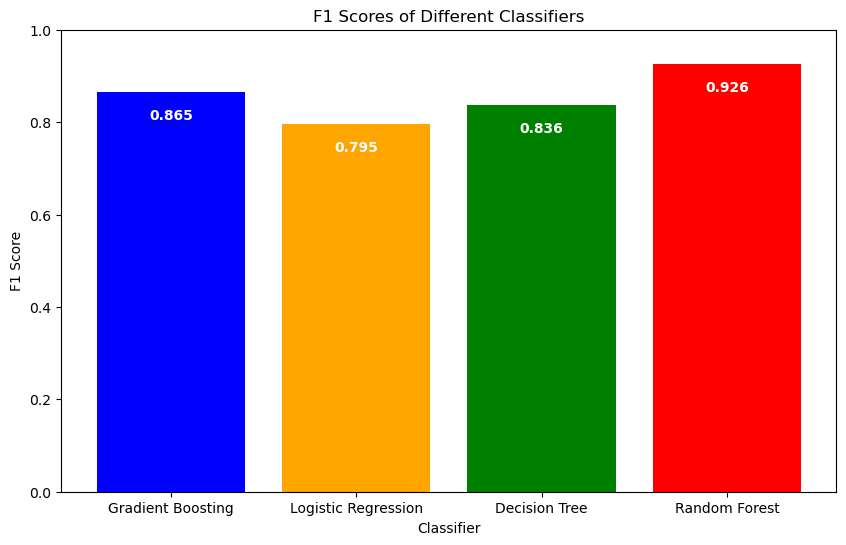

In [14]:
# F1 scores for each classifier
f1_scores = [f1_score_gb, f1_score_lr, f1_score_dt, f1_score_rf]

# Classifier names
classifiers = ['Gradient Boosting', 'Logistic Regression', 'Decision Tree', 'Random Forest']

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, f1_scores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Different Classifiers')

# Display the F1 score values on the bars
for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.3f}', 
             ha='center', va='center', color='white', fontweight='bold')

plt.ylim(0, 1)  # Set the y-axis limit to better visualize differences
plt.show()


Random Forest performs better than the other models 

#### Features Selection Using Recursive Feature Elimination with Cross-Validation

- Recursive Feature Elimination with Cross-Validation using Gradient Boosting Classifier as Estimator

In [16]:
# Initialize variables to store the best results
best_f1_score = 0
best_num_features = 0
best_selected_features = None

# Initialize RFECV
gb_rfecv_selector = RFECV(estimator=gb,
                          step=1,
                          cv=5,
                          scoring='f1')

# Fit RFECV on the training data
gb_rfecv_selector.fit(features_train, target_train)

# Transform the features based on the selected features
gb_sel_features_train = gb_rfecv_selector.transform(features_train)
gb_sel_features_test = gb_rfecv_selector.transform(features_test)

# Train the model using the selected features
gb.fit(gb_sel_features_train, target_train)
gb_rfecv_preds = gb.predict(gb_sel_features_test)

# Calculate F1 score
best_f1_score = round(f1_score(target_test, gb_rfecv_preds), 3)

# Display the best results
print("\nBest Results:")
print(f"Best F1 Score: {best_f1_score}")
print(f"Number of Features: {gb_rfecv_selector.n_features_}")
print(f"Selected Features: {features_train.columns[gb_rfecv_selector.support_]}")



Best Results:
Best F1 Score: 0.859
Number of Features: 66
Selected Features: Index(['Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality',
       'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket',
       'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Curr

Bar plot to compare Gradient Boosting (Baseline) model and Gradient Boosting (RFECV) model

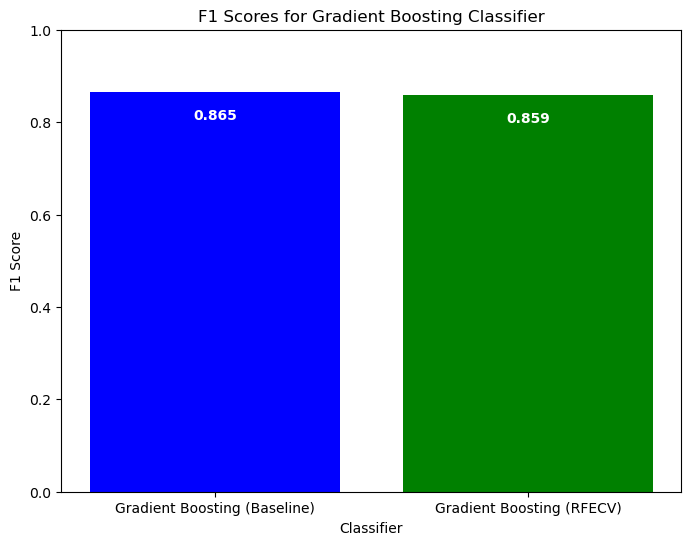

In [17]:
# Plotting
classifiers = ['Gradient Boosting (Baseline)', 'Gradient Boosting (RFECV)']
f1_scores = [f1_score_gb, best_f1_score]

plt.figure(figsize=(8, 6))
bars = plt.bar(classifiers, f1_scores, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Gradient Boosting Classifier')
plt.ylim(0, 1)

# Display the F1 score values on the bars
for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.3f}', 
             ha='center', va='center', color='white', fontweight='bold')

plt.show()

Recursive Feature Elimination with Cross-validation does not improve the model

- Recursive Feature Elimination with Cross-Validation using Logistic Regression Classifier as Estimator

In [18]:
# Initialize variables to store the best results
lr_f1_score = 0
lr_num_features = 0
lr_selected_features = None

# Initialize RFECV
lrc_rfecv_selector = RFECV(estimator=lr, step=1, cv=5, scoring='f1')

# Fit RFECV on the training data
lrc_rfecv_selector.fit(features_train, target_train)

# Transform the features based on the selected features
sel_features_train = lrc_rfecv_selector.transform(features_train)
sel_features_test = lrc_rfecv_selector.transform(features_test)

# Train the model using the selected features
lr.fit(sel_features_train, target_train)
lrc_rfecv_preds = lr.predict(sel_features_test)

# Calculate F1 score
lr_f1_score = round(f1_score(target_test, lrc_rfecv_preds), 3)

# Display the best results
print("\nBest Results:")
print(f"Best F1 Score: {lr_f1_score}")
print(f"Number of Features: {lrc_rfecv_selector.n_features_}")
print(f"Selected Features: {features_train.columns[lrc_rfecv_selector.support_]}")


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Best Results:
Best F1 Score: 0.794
Number of Features: 63
Selected Features: Index(['Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality',
       'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket',
       'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Adherent_Flag',
       'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
  

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bar plot to compare Logistic Regression (Baseline) model and Logistic Regression (RFECV) model

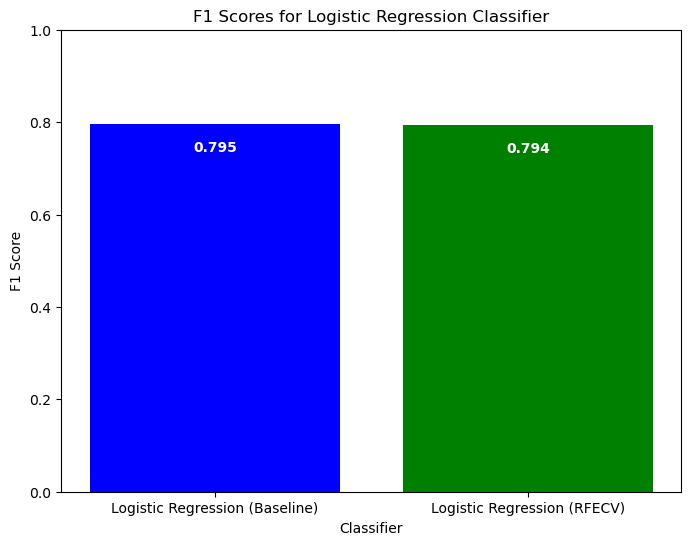

In [19]:
# Plotting
classifiers = ['Logistic Regression (Baseline)', 'Logistic Regression (RFECV)']
f1_scores = [f1_score_lr, lr_f1_score]

plt.figure(figsize=(8, 6))
bars = plt.bar(classifiers, f1_scores, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Logistic Regression Classifier')
plt.ylim(0, 1)

# Display the F1 score values on the bars
for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.3f}', 
             ha='center', va='center', color='white', fontweight='bold')

plt.show()

Recursive Feature Elimination with Cross-validation does not improve the model

- Recursive Feature Elimination with Cross-Validation using Decision Tree Classifier as Estimator

In [20]:
# Initialize variables to store the best results
dt_f1_score = 0
dt_num_features = 0
dt_selected_features = None

# Initialize RFECV
dt_rfecv_selector = RFECV(estimator=dt, step=1, cv=5, scoring='f1')

# Fit RFECV on the training data
dt_rfecv_selector.fit(features_train, target_train)

# Transform the features based on the selected features
sel_features_train = dt_rfecv_selector.transform(features_train)
sel_features_test = dt_rfecv_selector.transform(features_test)

# Train the model using the selected features
dt.fit(sel_features_train, target_train)
dt_rfecv_preds = dt.predict(sel_features_test)

# Calculate F1 scored
dt_f1_score = round(f1_score(target_test, dt_rfecv_preds), 3)

# Display the best results
print("\nBest Results:")
print(f"Best F1 Score: {dt_f1_score}")
print(f"Number of Features: {dt_rfecv_selector.n_features_}")
print(f"Selected Features: {features_train.columns[dt_rfecv_selector.support_]}")


Best Results:
Best F1 Score: 0.837
Number of Features: 66
Selected Features: Index(['Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality',
       'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket',
       'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Curr

Bar plot to compare Decision Tree (Baseline) model and Decision Tree (RFECV) model

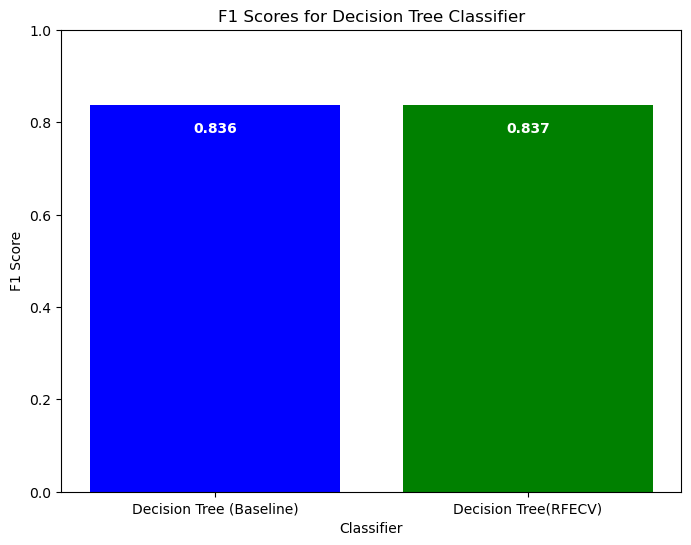

In [21]:
# Plotting
classifiers = ['Decision Tree (Baseline)', 'Decision Tree(RFECV)']
f1_scores = [f1_score_dt, dt_f1_score]

plt.figure(figsize=(8, 6))
bars = plt.bar(classifiers, f1_scores, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Decision Tree Classifier')
plt.ylim(0, 1)

# Display the F1 score values on the bars
for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.3f}', 
             ha='center', va='center', color='white', fontweight='bold')

plt.show()

- Recursive Feature Elimination with Cross-Validation using Random Forest Classifier as Estimator

In [22]:
# Initialize RFECV
rf_rfecv_selector = RFECV(estimator=rf, step=1, cv=5, scoring='f1')

# Fit RFECV on the training data
rf_rfecv_selector.fit(features_train, target_train)

# Transform the features based on the selected features
sel_features_train = rf_rfecv_selector.transform(features_train)
sel_features_test = rf_rfecv_selector.transform(features_test)

# Store the selected features in a variable
selected_rf_features = features_train.columns[rf_rfecv_selector.support_]

# Train the model using the selected features
rf.fit(sel_features_train, target_train)
dt_rfecv_preds = rf.predict(sel_features_test)

# Calculate F1 score
rf_f1_score = round(f1_score(target_test, dt_rfecv_preds), 3)

# Display the best results
print("\nBest Results:")
print(f"Best F1 Score: {rf_f1_score}")
print(f"Number of Features: {rf_rfecv_selector.n_features_}")
print(f"Selected Features: {selected_rf_features}")



Best Results:
Best F1 Score: 0.925
Number of Features: 52
Selected Features: Index(['Race', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dor

Random Forest Feature Importance Visualized

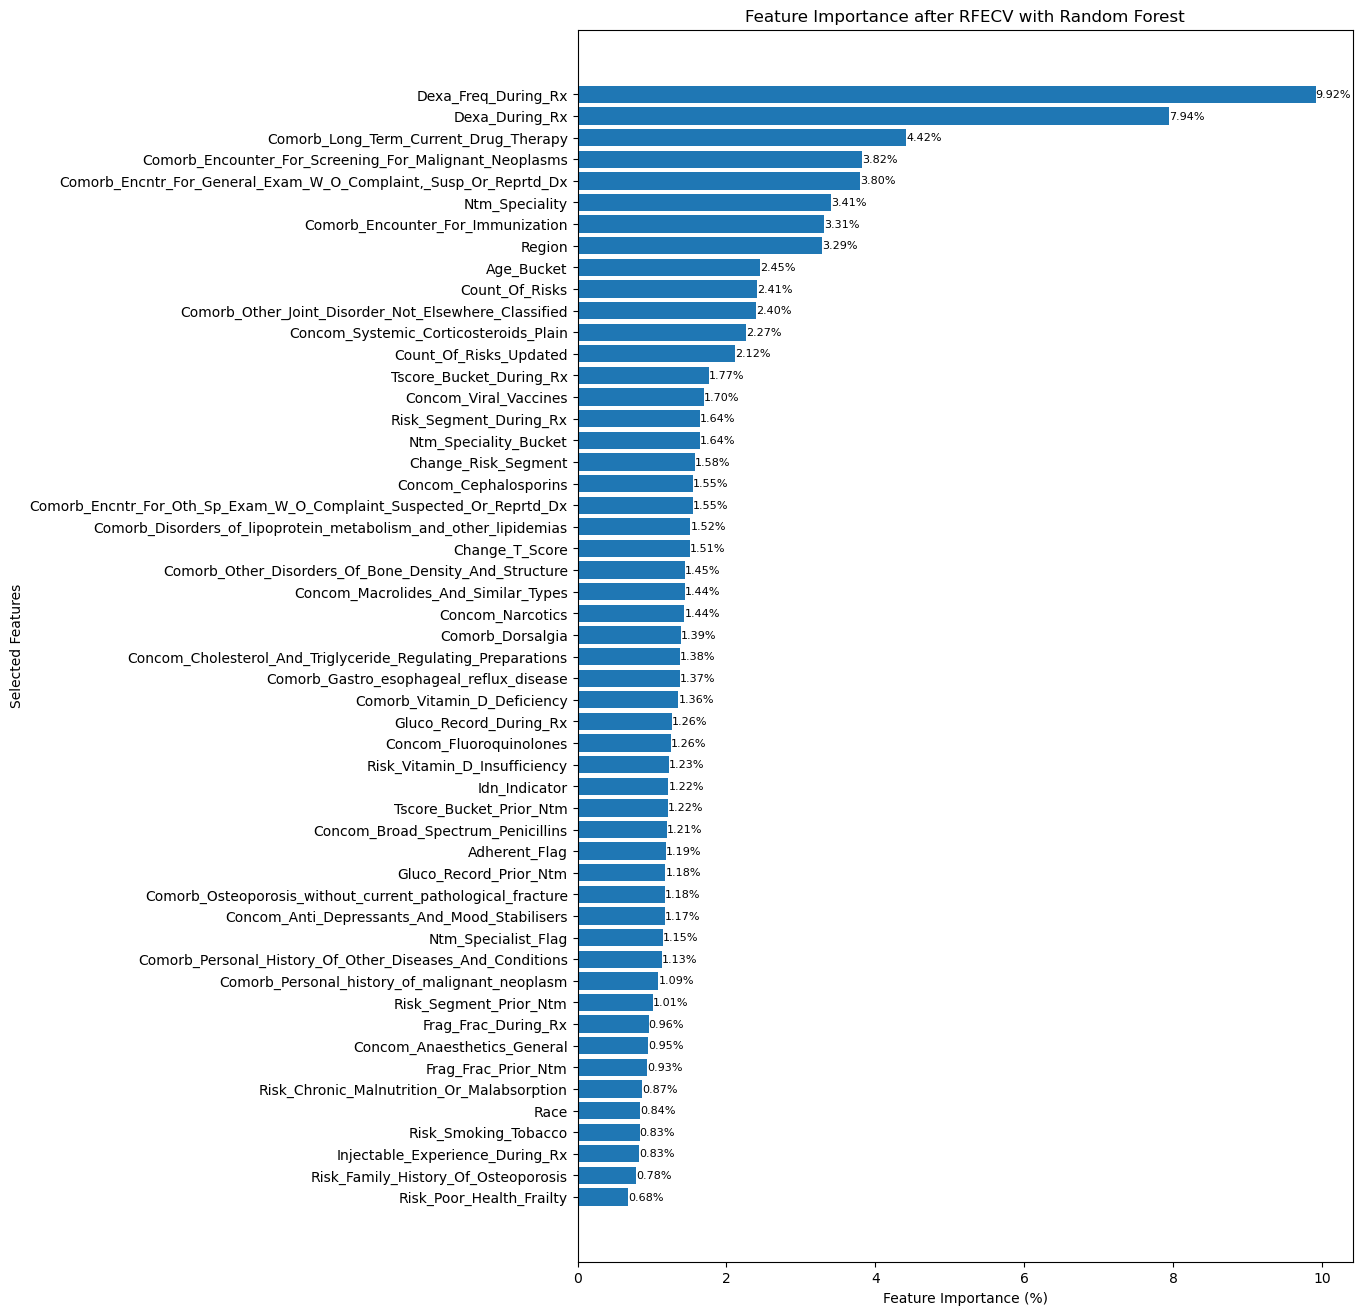

In [31]:
# Get the feature importances from the trained Random Forest model
feature_importances = rf.feature_importances_

# Normalize to percentages
feature_importances_percentage = (feature_importances / np.sum(feature_importances)) * 100

# Get the selected features from RFECV
selected_features = features_train.columns[rf_rfecv_selector.support_]

# Sort indices based on feature importances
indices = np.argsort(feature_importances_percentage)

# Plotting
plt.figure(figsize=(10 , 16))
bars = plt.barh(range(len(indices)), feature_importances_percentage[indices], align="center")
plt.yticks(range(len(indices)), selected_features[indices])
plt.xlabel('Feature Importance (%)')
plt.ylabel('Selected Features')
plt.title('Feature Importance after RFECV with Random Forest')

# Display the percentage values on each bar
for bar, percentage in zip(bars, feature_importances_percentage[indices]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{percentage:.2f}%', 
             va='center', ha='left', fontsize=8, color='black')

plt.show()


Bar plot to compare Random Forest (Baseline) model and Random Forest (RFECV) model

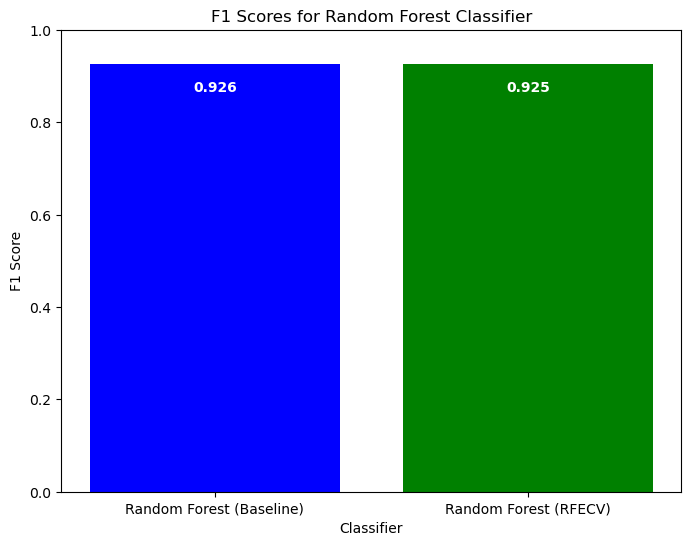

In [24]:
# Plotting
classifiers = ['Random Forest (Baseline)', 'Random Forest (RFECV)']
f1_scores = [f1_score_rf, rf_f1_score]

plt.figure(figsize=(8, 6))
bars = plt.bar(classifiers, f1_scores, color=['blue', 'green'])
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Random Forest Classifier')
plt.ylim(0, 1)

# Display the F1 score values on the bars
for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.3f}', 
             ha='center', va='center', color='white', fontweight='bold')

plt.show()

Visualizing the models' performance

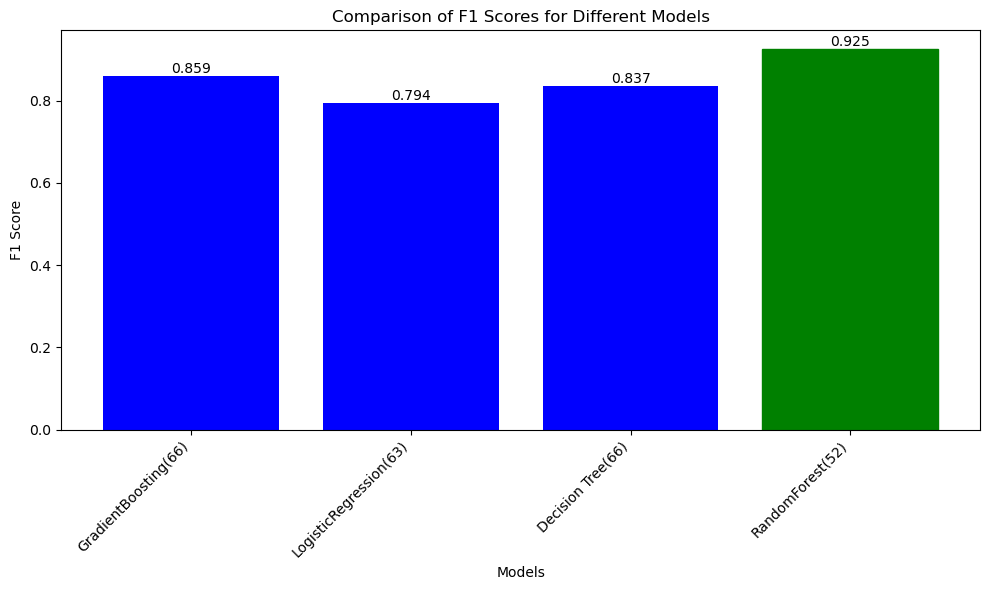

In [25]:
# Dictionary of F1 scores for each model
f1_scores = {'GradientBoosting(66)': 0.859,
             'LogisticRegression(63)': 0.794,
             'Decision Tree(66)': 0.837,
             'RandomForest(52)': 0.925
             }

# Find the model with the highest F1 score
best_model = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_model]

# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue' if model != best_model else 'green' for model in f1_scores.keys()])
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Different Models')
plt.xticks(rotation=45, ha='right')

# Add text annotations for each bar
for i, f1_score in enumerate(f1_scores.values()):
    plt.text(i, f1_score, f'{f1_score:.3f}', ha='center', va='bottom', color='black', fontsize=10)

# Highlight the bar of the best model
best_model_index = list(f1_scores.keys()).index(best_model)
bars[best_model_index].set_color('green')

plt.tight_layout()
plt.show()



Random Forest does better with F1 Score of 0.925 and 52 features selected

#### Tuning Hyperparameters For Random Forest Classifier

In [27]:
# Define the hyperparameters to search over
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf, parameters, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(features_train, target_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best score
print("Best score:", grid_search.best_score_)


Best hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best score: 0.8793955973388815


The model with the best performance by F1 Score is Random Forest Classifier with F1 Score of 0.925 and 52 selected features